## Import Packages

In [1]:
# imports
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

from worldllm_envs.base import BaseRuleEnv

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load the data

In [2]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data

test_trajectories = BaseRuleEnv.load_test_dataset("../worldllm_envs/worldllm_envs/playground/data/test_dataset.json")
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.lst_diff):
        test_observations.append(observation)
nb_transitions = len(test_observations)

#Load performance without rules
with open("../outputs/no_rule_ne/2024-12-12/22-28-17_438/all.json", "r") as f:
    norule_data = json.load(f)
    norule_likelihood_lst = norule_data["metrics"]["test_likelihoods_best"]
    norule_transition_likelihood_lst = []
    for lst_trajectory_likelihood in norule_data["metrics"]["test_transition_scores_best"]:
        norule_transition_likelihood_lst.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])


In [ ]:
# Load the data
shared_extension = "_ne_wt3"
baselines_to_load = [
    "pb","rb","cp","db","ll","alp"
]
baselines_names = ["PB","RB", "CP", "DB","LL","ALP"]
assert len(baselines_to_load) == len(baselines_names)
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_best_rules = {}
all_best_likelihoods = {}
all_best_transition_ll = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "../outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            lst_dir = sorted(os.listdir(path_start + f_day))
            for f_hour in lst_dir:
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        raise NotImplementedError("IS is not supported anymore")
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_best_rules = []
        reshaped_best_likelihood = []
        reshaped_best_transition_ll = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            nb_particles = data["metrics"]["nb_rules"]
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            best_rules = np.array(data["metrics"]["best_rule"])
            best_rule_test_ll = np.array(data["metrics"]["test_likelihoods_best"])
            best_rule_test_transition_ll = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores_best"]:
                best_rule_test_transition_ll.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_best_rules.append(best_rules.reshape((-1, nb_particles)).transpose())
            reshaped_best_likelihood.append(best_rule_test_ll.reshape((-1, nb_particles)).transpose())
            reshaped_best_transition_ll.append(
                np.array(best_rule_test_transition_ll).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_best_rules[b_name] = np.concatenate(reshaped_best_rules, axis=0)
        all_best_likelihoods[b_name] = np.concatenate(reshaped_best_likelihood, axis=0)
        all_best_transition_ll[b_name] = np.concatenate(reshaped_best_transition_ll, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load pb --------------------------------
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_438/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_439/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_440/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_441/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_442/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_443/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-19-45_444/all.json
Loaded: ../outputs/pb_ne_wt3/2024-12-12/10-20-07_445/all.json
-------------------------------- Load rb --------------------------------
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-21-08_438/all.json
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-21-40_439/all.json
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-21-40_440/all.json
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-21-40_441/all.json
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-23-04_443/all.json
Loaded: ../outputs/rb_ne_wt3/2024-12-12/10-23-

In [ ]:
dict_index_transition = {"standing": [], "holding1": [], "holding2": [], "transformP": [], "transformSH": [], "transformBH": [], "nothing": []}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["standing"].append(incr)
    elif "holding" in transition:
        if " and " in transition:
            dict_index_transition["holding2"].append(incr)
        else:
            dict_index_transition["holding1"].append(incr)
    elif "transform" in transition:
        if "into the carrot" in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["transformP"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["transformSH"].append(incr)
        elif "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["transformBH"].append(incr)
        else:
            raise ValueError("Unknown transform")
    elif "Nothing" in transition:
        dict_index_transition["nothing"].append(incr)
    else:
        raise ValueError("Unknown transition")

In [ ]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

standing 120
holding1 20
holding2 7
transformP 12
transformSH 6
transformBH 3
nothing 0


## Rules generated

In [ ]:
all_best_rules["ALP"].shape

In [6]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'PB' Color: Red
Baseline: 'RB' Color: Green
Baseline: 'CP' Color: Blue
Baseline: 'DB' Color: Magenta
Baseline: 'LL' Color: Cyan
Baseline: 'ALP' Color: White
-----rule-----:0: '1. Empty inventory (0/2).\n2. Find the nearest water source, always ends with "You are standing on the water."\n3. Collect water: "You pick up the water." leads to "You are holding the water."\n4. After water, move to the specified object: "You go to [object]." becomes "You are standing on the [object]."\n5. Transform all non-water items with water into the object itself: "You give the water [object]." turns into "The water and the [object] transform into the [object]." if the object is not water itself', likelihood: -370.813141
-----rule-----:1: '1. Empty inventory (0/2).\n2. Find the nearest water source, always ends with "You are standing on the water."\n3. Collect water: "You pick up the water." leads to "You are holding the water."\n4. After water, move to the specified o

In [7]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for PB: [348, 47, 58, 121, 102, 175, 123, 150]
Number of same rules per particle for RB: [0, 0, 2, 0, 0, 1, 0, 0]
Number of same rules per particle for CP: [31, 47, 7, 97, 10, 23, 109, 98]
Number of same rules per particle for DB: [247, 19, 11, 199, 412, 39, 42, 19]
Number of same rules per particle for LL: [0, 0, 0, 0, 0, 0, 0, 3]
Number of same rules per particle for ALP: [0, 0, 0, 0, 0, 0, 0, 0]


## Comparison across seeds

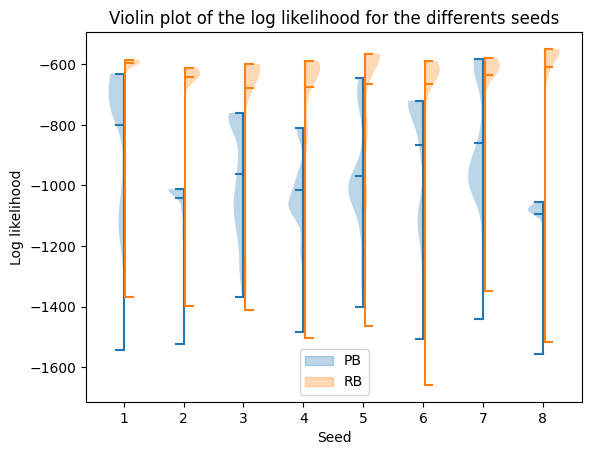

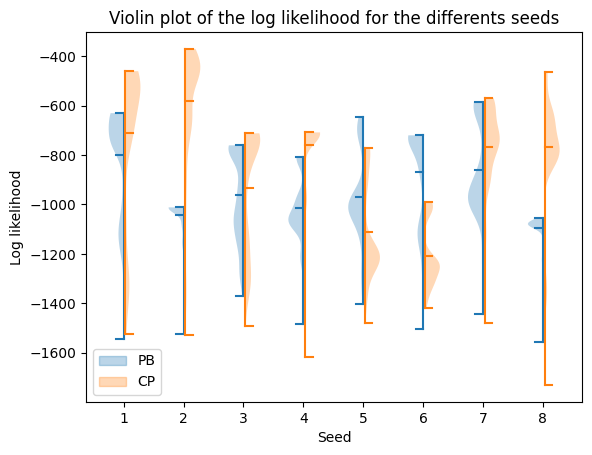

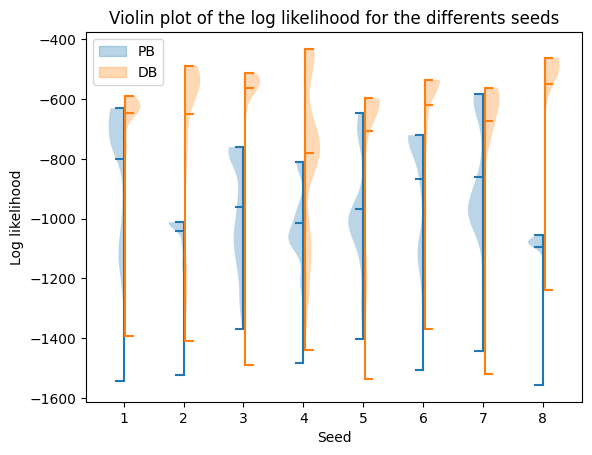

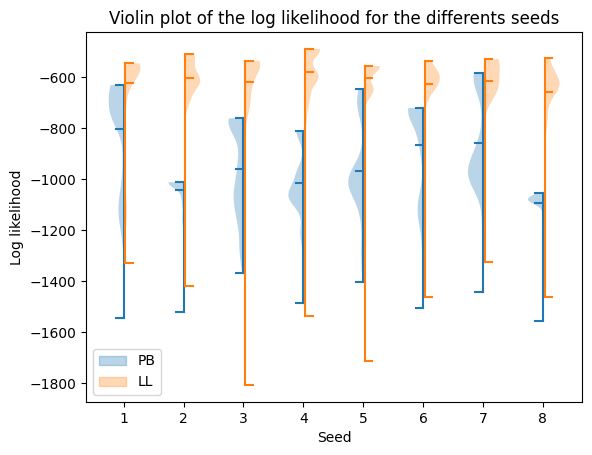

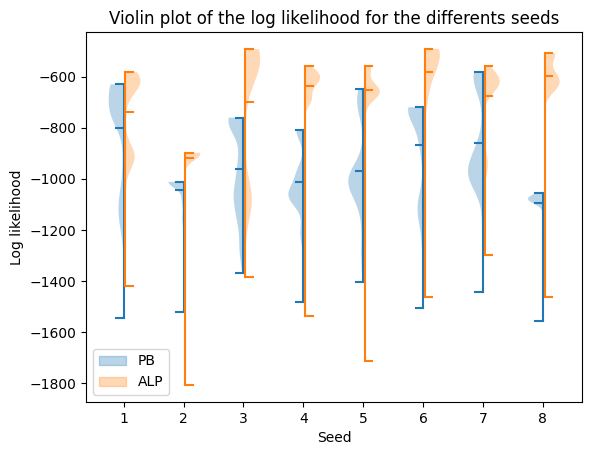

In [8]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_best_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_best_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_best_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

## Comparaison collecte de données

In [9]:
for transi_type, value in dict_index_transition.items():
    print(transi_type +": "+ str(len(value)))

standing: 120
holding1: 20
holding2: 7
transformP: 12
transformSH: 6
transformBH: 3
nothing: 0


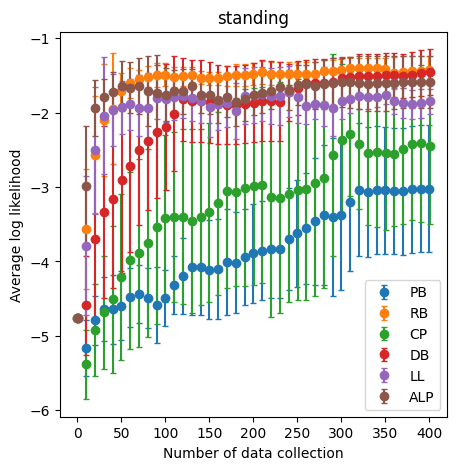

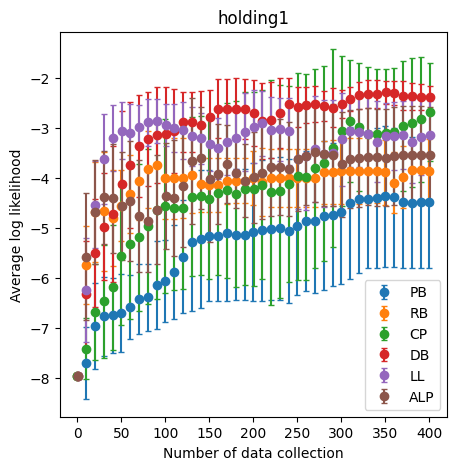

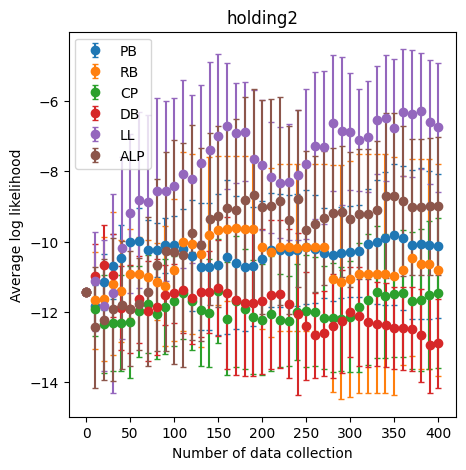

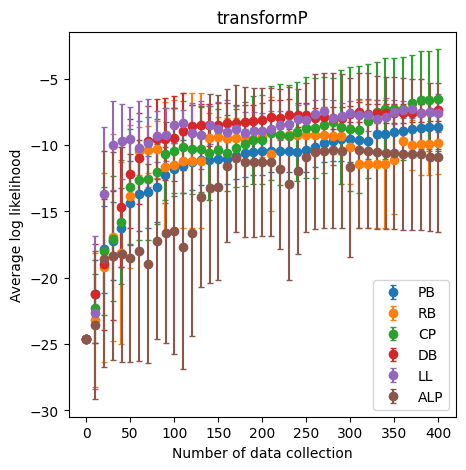

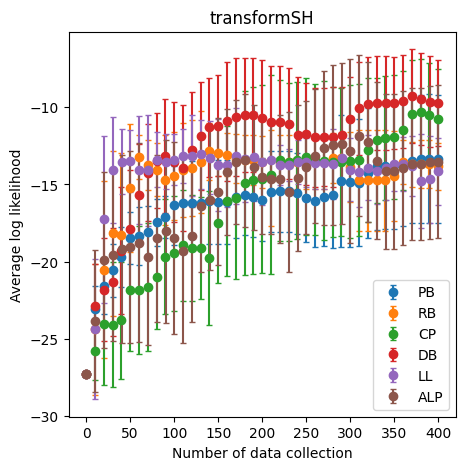

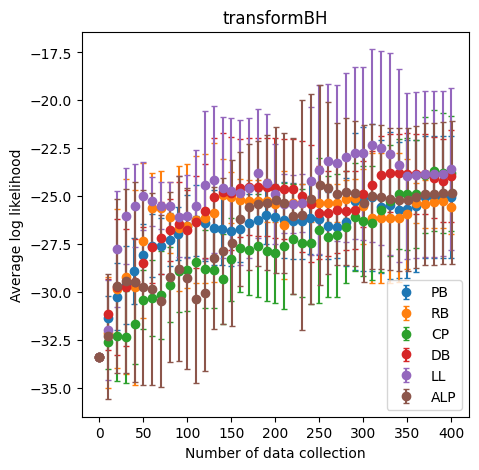

/tmp/ipykernel_27049/210991374.py:8: RuntimeWarning: Mean of empty slice.
  _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_27049/210991374.py:11: RuntimeWarning: Mean of empty slice.
  _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)


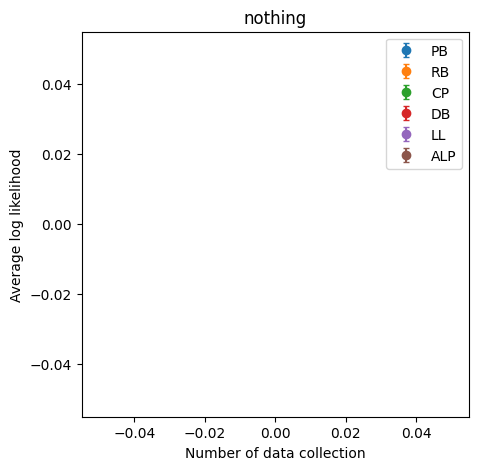

In [10]:
average_size = 10
kernel = np.ones(average_size) / average_size
for transi_type in dict_index_transition:
    plt.figure(figsize=(5,5))

    for incr,b_name in enumerate(all_baselines_name):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        #Plot
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=b_name, capsize=2, fmt='o')
    plt.legend()
    plt.xlabel("Number of data collection")
    plt.ylabel("Average log likelihood")
    plt.title(f"{transi_type}")
    plt.show()

/tmp/ipykernel_27049/2694442658.py:9: RuntimeWarning: Mean of empty slice.
  _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
/tmp/ipykernel_27049/2694442658.py:12: RuntimeWarning: Mean of empty slice.
  _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)


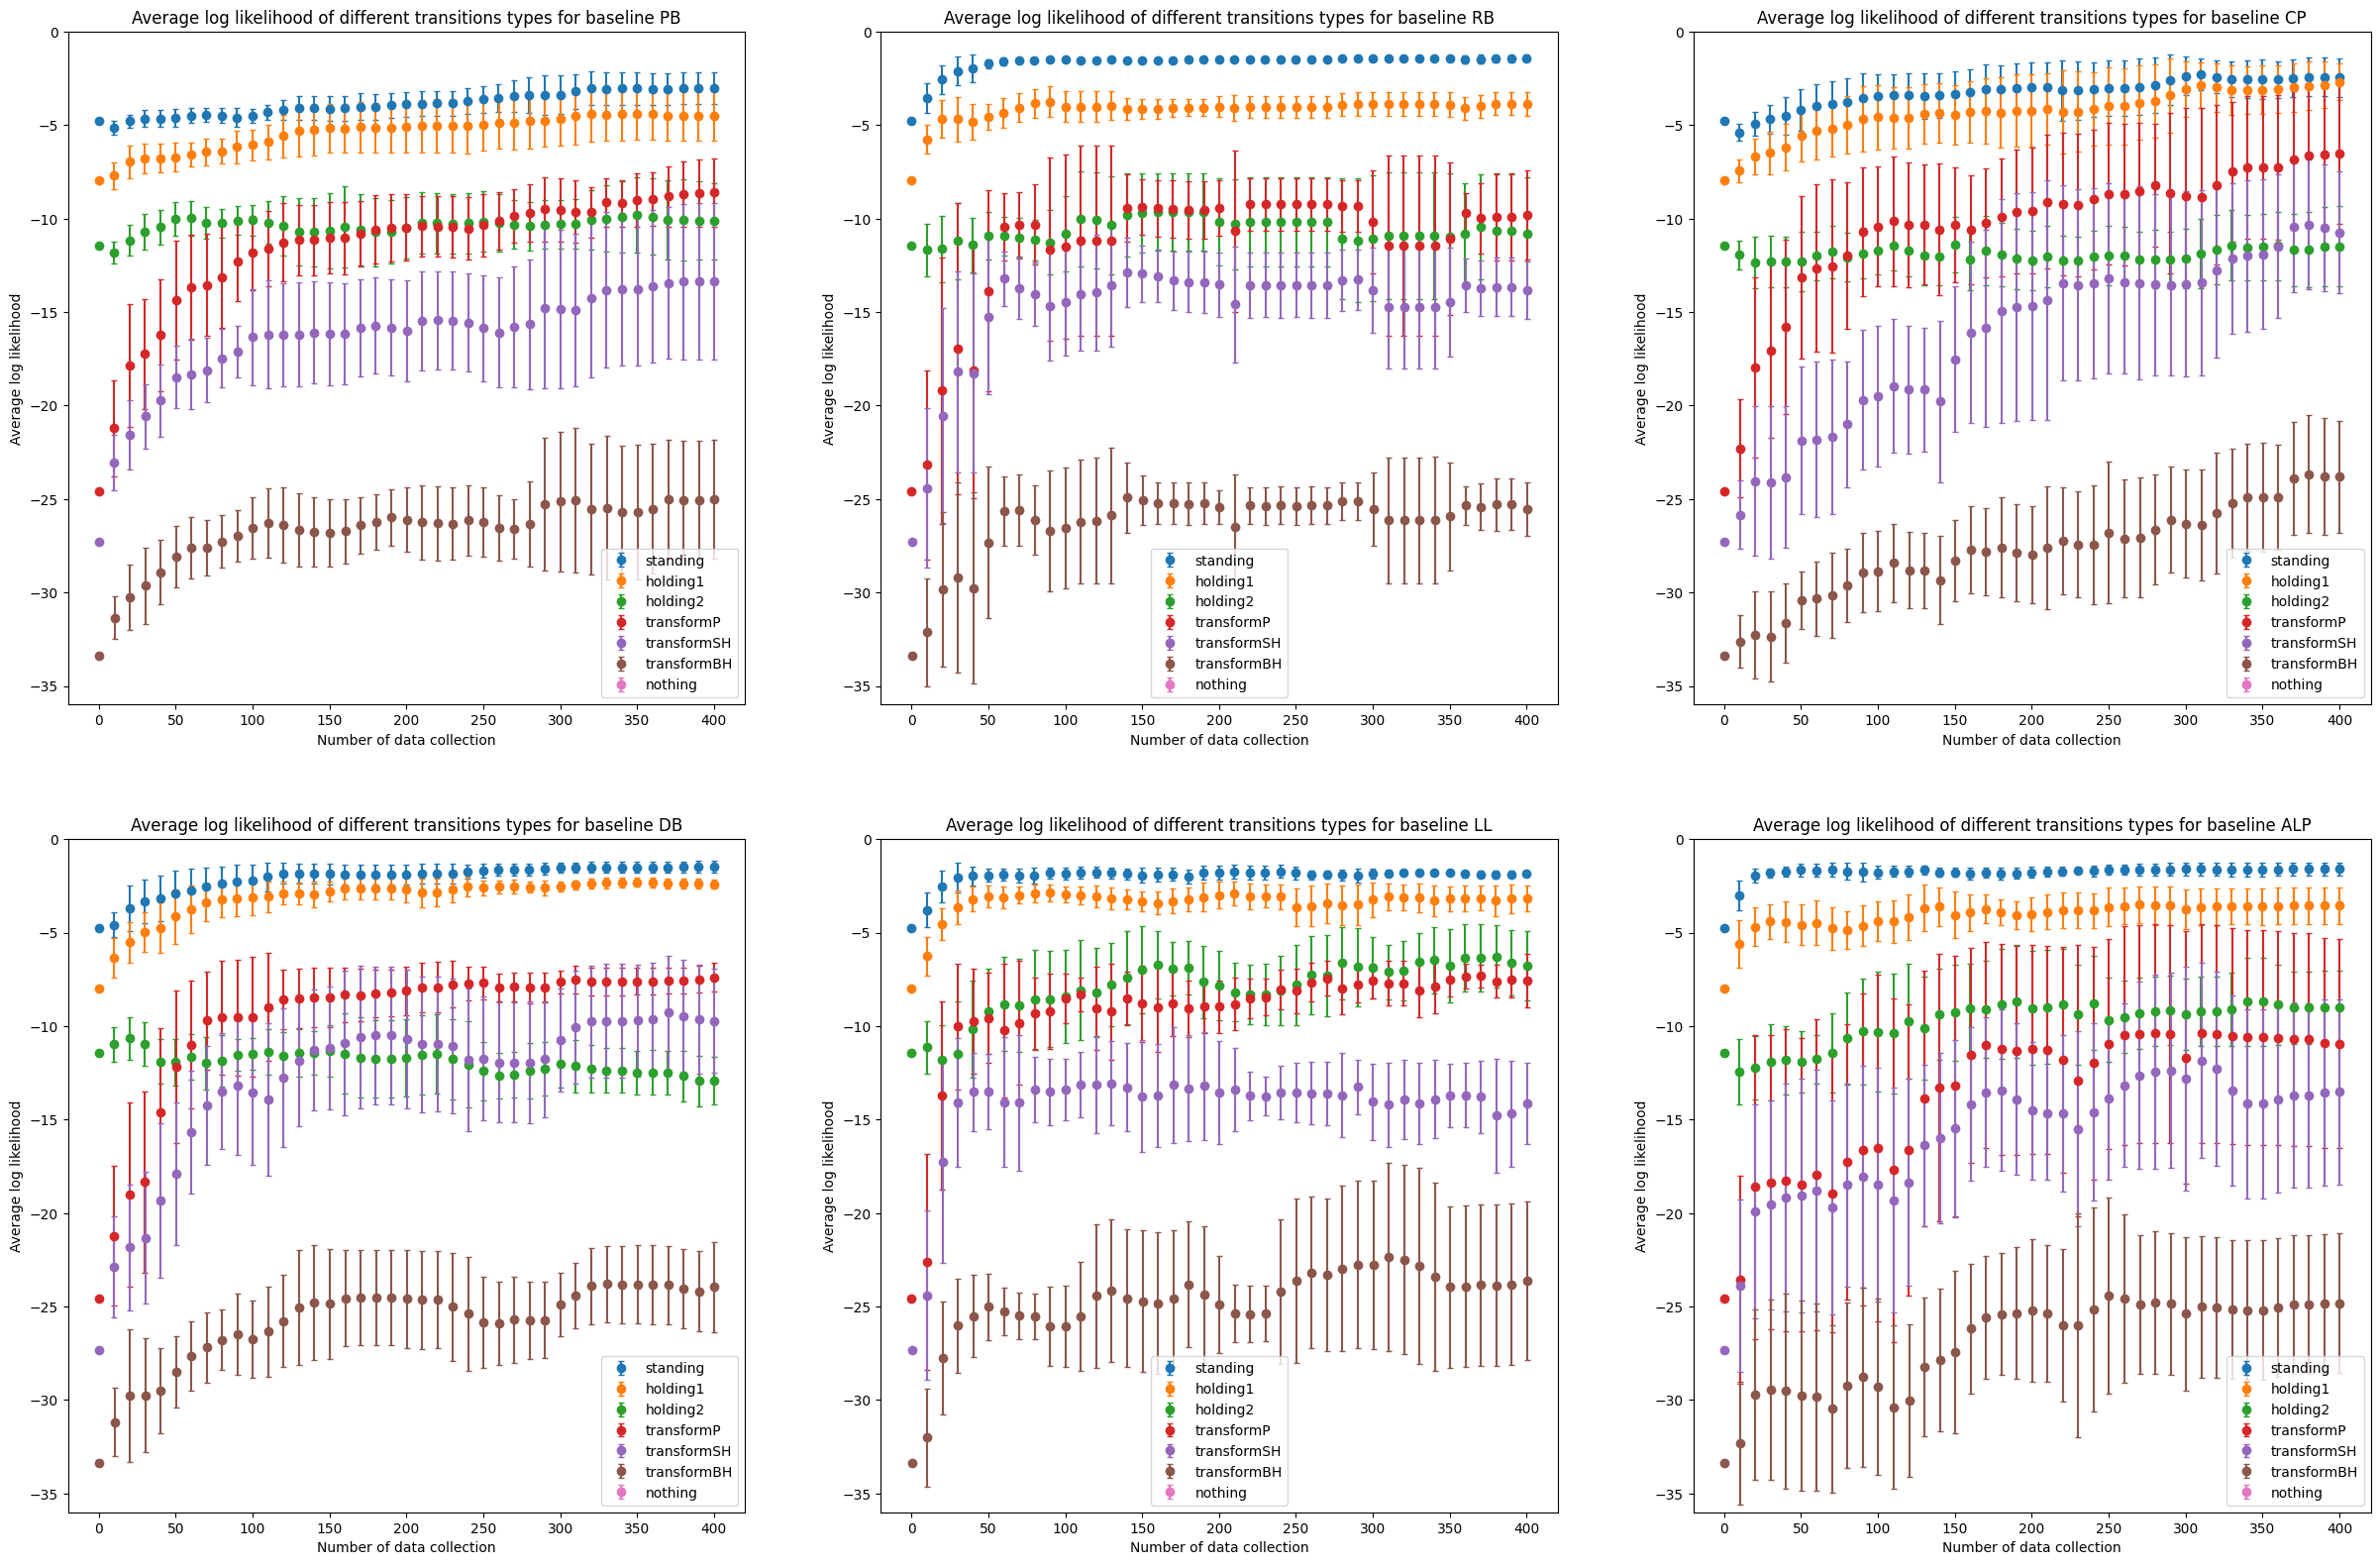

In [11]:
average_size = 10
kernel = np.ones(average_size) / average_size
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
for incr_m, b_name in enumerate(all_baselines_name):
    plt.subplot(3,3,incr_m+1)
    for incr, transi_type in enumerate(dict_index_transition):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        average_mean_ll = np.convolve(_ll_per_transition.mean(axis=0), kernel, mode='valid')[::average_size]
        average_std_ll = np.convolve(_ll_per_transition.std(axis=0), kernel, mode='valid')[::average_size]
        average_mean_ll = np.insert(average_mean_ll,0, _norule_likelihood_transition.mean(axis=0), axis=0)
        average_std_ll = np.insert(average_std_ll,0, _norule_likelihood_transition.std(axis=0), axis=0)
        #Plot
        plt.errorbar(average_size*np.arange(len(average_mean_ll))+ incr*0.05, average_mean_ll, yerr=average_std_ll, label=transi_type, capsize=2, fmt='o')
    
    plt.legend()
    plt.xlabel("Number of data collection")
    plt.ylim((-36,0))
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for baseline {b_name}")


## Embeddings

In [14]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [15]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

In [ ]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::20].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -700
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::20].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [18]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

In [ ]:
# # Enable interactive backend
# %matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name][:, ::20].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name][:, ::20].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name][:, ::20].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -720
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name][:, ::20].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name][:, ::20].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()